This kernels aims at segmenting the cervix using the technique presented in this paper: https://www.researchgate.net/publication/24041301_Automatic_Detection_of_Anatomical_Landmarks_in_Uterine_Cervix_Images

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import math
from sklearn import mixture
from sklearn.utils import shuffle
from skimage import measure
from glob import glob
import os

from subprocess import check_output
print(check_output(["ls", "./input"]).decode("utf8"))

TRAIN_DATA = "./input/train"
type_1_files = glob(os.path.join(TRAIN_DATA, "Type_1", "*.jpg"))
type_1_ids = np.array([s[len(os.path.join(TRAIN_DATA, "Type_1"))+1:-4] for s in type_1_files])
type_2_files = glob(os.path.join(TRAIN_DATA, "Type_2", "*.jpg"))
type_2_ids = np.array([s[len(os.path.join(TRAIN_DATA, "Type_2"))+1:-4] for s in type_2_files])
type_3_files = glob(os.path.join(TRAIN_DATA, "Type_3", "*.jpg"))
type_3_ids = np.array([s[len(os.path.join(TRAIN_DATA, "Type_3"))+1:-4] for s in type_3_files])

type_1_ids = type_1_ids[:30]

def get_filename(image_id, image_type):
    """
    Method to get image file path from its id and type   
    """
    if image_type == "Type_1" or \
        image_type == "Type_2" or \
        image_type == "Type_3":
        data_path = os.path.join(TRAIN_DATA, image_type)
    elif image_type == "Test":
        data_path = TEST_DATA
    elif image_type == "AType_1" or \
          image_type == "AType_2" or \
          image_type == "AType_3":
        data_path = os.path.join(ADDITIONAL_DATA, image_type)
    else:
        raise Exception("Image type '%s' is not recognized" % image_type)

    ext = 'jpg'
    return os.path.join(data_path, "{}.{}".format(image_id, ext))

def get_image_data(image_id, image_type):
    """
    Method to get image data as np.array specifying image id and type
    """
    fname = get_filename(image_id, image_type)
    img = cv2.imread(fname)
    assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

train



First, we crop the image in order to remove the circular frames that might be present. This is done by finding the largest inscribed rectangle to the thresholded image. The image is then cropped to this rectangle. (see these videos for an explanation of the algorithm: https://www.youtube.com/watch?v=g8bSdXCG-lA, https://www.youtube.com/watch?v=VNbkzsnllsU)

In [12]:
def maxHist(hist):
    maxArea = (0, 0, 0)
    height = []
    position = []
    for i in range(len(hist)):
        if (len(height) == 0):
            if (hist[i] > 0):
                height.append(hist[i])
                position.append(i)
        else: 
            if (hist[i] > height[-1]):
                height.append(hist[i])
                position.append(i)
            elif (hist[i] < height[-1]):
                while (height[-1] > hist[i]):
                    maxHeight = height.pop()
                    area = maxHeight * (i-position[-1])
                    if (area > maxArea[0]):
                        maxArea = (area, position[-1], i)
                    last_position = position.pop()
                    if (len(height) == 0):
                        break
                position.append(last_position)
                if (len(height) == 0):
                    height.append(hist[i])
                elif(height[-1] < hist[i]):
                    height.append(hist[i])
                else:
                    position.pop()    
    while (len(height) > 0):
        maxHeight = height.pop()
        last_position = position.pop()
        area =  maxHeight * (len(hist) - last_position)
        if (area > maxArea[0]):
            maxArea = (area, len(hist), last_position)
    return maxArea
            

def maxRect(img):
    maxArea = (0, 0, 0)
    addMat = np.zeros(img.shape)
    for r in range(img.shape[0]):
        if r == 0:
            addMat[r] = img[r]
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
        else:
            addMat[r] = img[r] + addMat[r-1]
            addMat[r][img[r] == 0] *= 0
            area = maxHist(addMat[r])
            if area[0] > maxArea[0]:
                maxArea = area + (r,)
    return (int(maxArea[3]+1-maxArea[0]/abs(maxArea[1]-maxArea[2])), maxArea[2], maxArea[3], maxArea[1], maxArea[0])

def cropCircle(img):
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    img = cv2.resize(img, dsize=tile_size)
            
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY);
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    _, contours, _ = cv2.findContours(thresh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    main_contour = sorted(contours, key = cv2.contourArea, reverse = True)[0]
            
    ff = np.zeros((gray.shape[0],gray.shape[1]), 'uint8') 
    cv2.drawContours(ff, main_contour, -1, 1, 15)
    ff_mask = np.zeros((gray.shape[0]+2,gray.shape[1]+2), 'uint8')
    cv2.floodFill(ff, ff_mask, (int(gray.shape[1]/2), int(gray.shape[0]/2)), 1)
    #cv2.circle(ff, (int(gray.shape[1]/2), int(gray.shape[0]/2)), 3, 3, -1)
    
    rect = maxRect(ff)
    img_crop = img[min(rect[0],rect[2]):max(rect[0],rect[2]), min(rect[1],rect[3]):max(rect[1],rect[3])]
    cv2.rectangle(ff,(min(rect[1],rect[3]),min(rect[0],rect[2])),(max(rect[1],rect[3]),max(rect[0],rect[2])),3,2)

    #plt.subplot(121)
    #plt.imshow(img)
    #plt.subplot(122)
    #plt.imshow(ff)
    #plt.show()
    
    return img_crop

“For an initial delineation of the cervix, we use two features: 

 - the *a* color channel of the source image in Lab color space (the higher the value of *a* , the “redder” the pixel color)
 - *R*, the distance of a pixel from the image center. The *R* feature provides spatial information and supports the extraction of continuous regions within the image plane."

In [13]:
def Ra_space(img, Ra_ratio, a_threshold):
    imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB);
    w = img.shape[0]
    h = img.shape[1]
    Ra = np.zeros((w*h, 2))
    for i in range(w):
        for j in range(h):
            R = math.sqrt((w/2-i)*(w/2-i) + (h/2-j)*(h/2-j))
            Ra[i*h+j, 0] = R
            Ra[i*h+j, 1] = min(imgLab[i][j][1], a_threshold)
            
    Ra[:,0] /= max(Ra[:,0])
    Ra[:,0] *= Ra_ratio
    Ra[:,1] /= max(Ra[:,1])

    return Ra

"The image is separated next into two clusters in the 2-D (*a-R*) feature space; we use Gaussian mixture modeling, initialized by a K-means procedure."

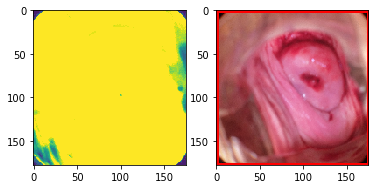

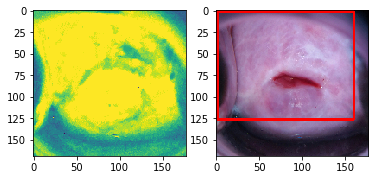

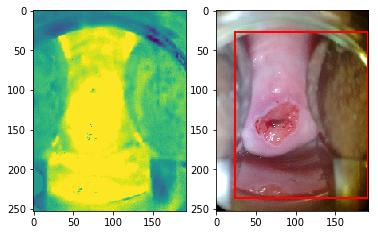

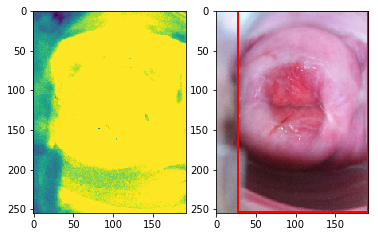

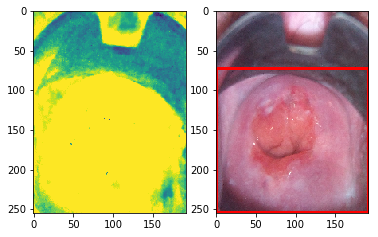

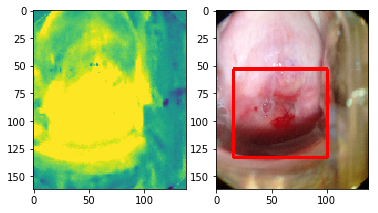

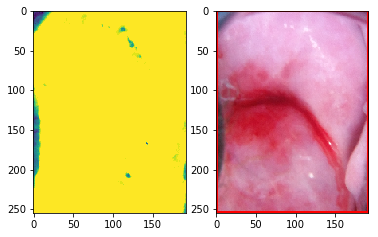

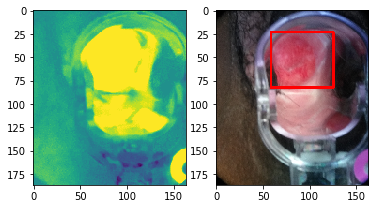

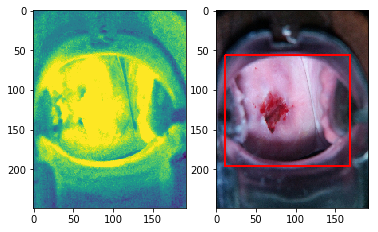

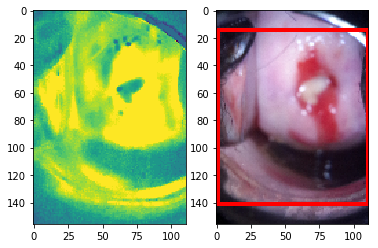

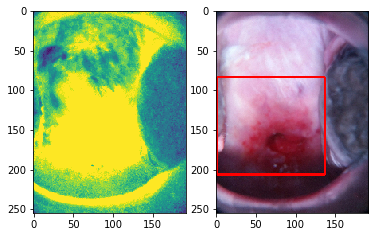

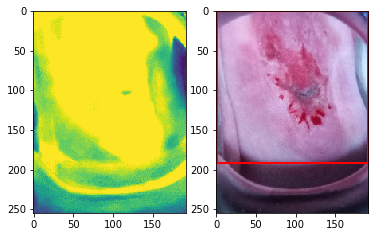

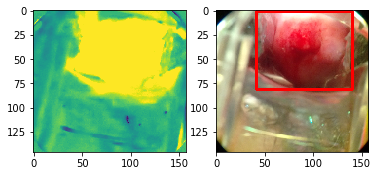

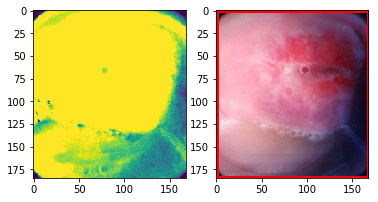

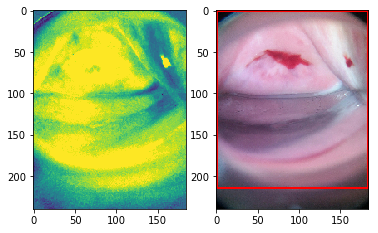

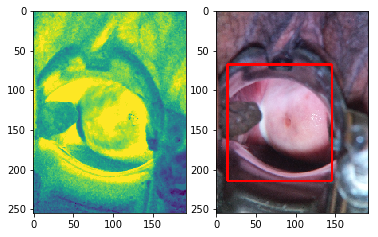

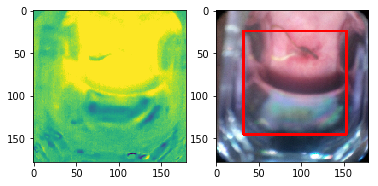

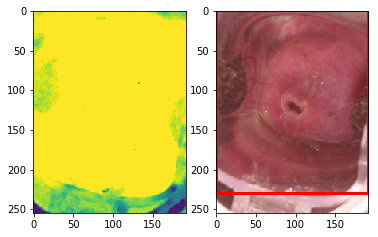

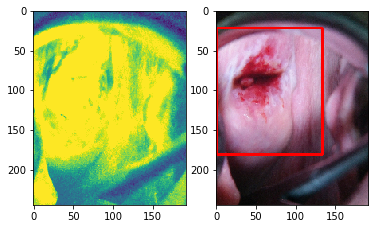

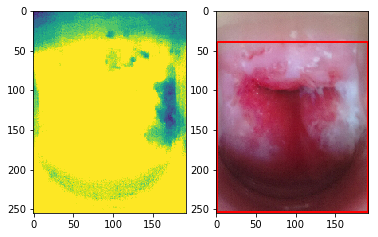

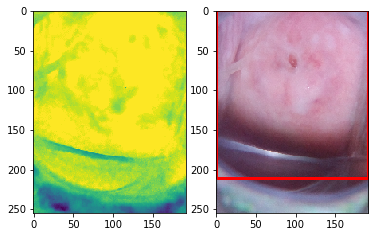

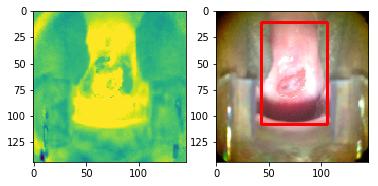

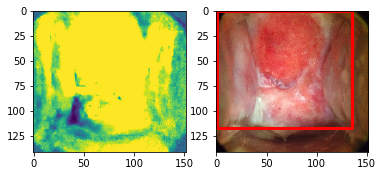

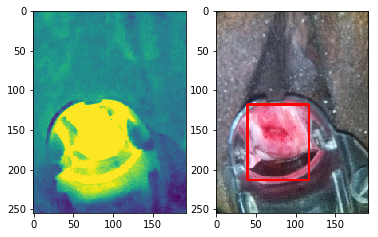

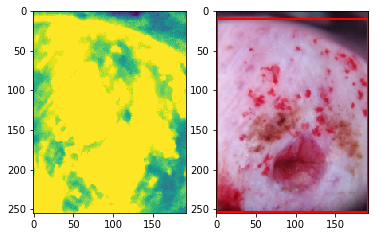

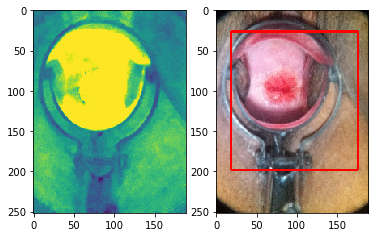

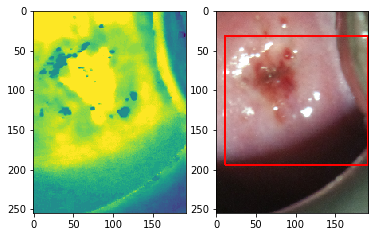

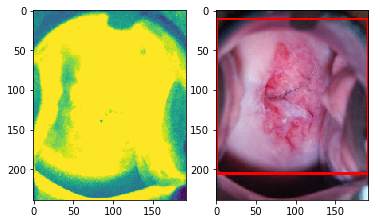

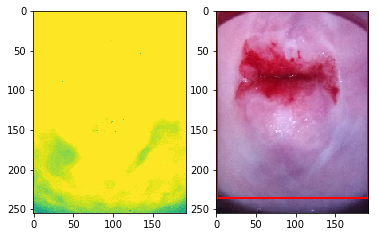

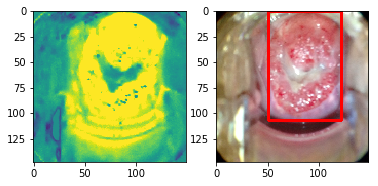

In [14]:
for k, type_ids in enumerate([type_1_ids]):
    m = len(type_ids)
    train_ids = sorted(type_ids)
    counter = 0
    
    for i in range(m):                
        image_id = train_ids[counter] 
        counter += 1

        img = get_image_data(image_id, 'Type_%i' % (k+1))

        img = cropCircle(img)
        w = img.shape[0]
        h = img.shape[1]
                        
        imgLab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB);
        
        # Saturating the a-channel at 150 helps avoiding wrong segmentation
        # in the case of close-up cervix pictures where the bloody os is falsly segemented as the cervix.
        Ra = Ra_space(img, 1.0, 150) 
        a_channel = np.reshape(Ra[:,1], (w,h))
        plt.subplot(121)
        plt.imshow(a_channel) 

        g = mixture.GaussianMixture(n_components = 2, covariance_type = 'diag', random_state = 0, init_params = 'kmeans')
        image_array_sample = shuffle(Ra, random_state=0)[:1000]
        g.fit(image_array_sample)
        labels = g.predict(Ra)
        labels += 1 # Add 1 to avoid labeling as 0 since regionprops ignores the 0-label.
    
        # The cluster that has the highest a-mean is selected.
        labels_2D = np.reshape(labels, (w,h))
        gg_labels_regions = measure.regionprops(labels_2D, intensity_image = a_channel)
        gg_intensity = [prop.mean_intensity for prop in gg_labels_regions]
        cervix_cluster = gg_intensity.index(max(gg_intensity)) + 1

        mask = np.zeros((w * h,1),'uint8')
        mask[labels==cervix_cluster] = 255
        mask_2D = np.reshape(mask, (w,h))

        cc_labels = measure.label(mask_2D, background=0)
        regions = measure.regionprops(cc_labels)
        areas = [prop.area for prop in regions]

        regions_label = [prop.label for prop in regions]
        largestCC_label = regions_label[areas.index(max(areas))]
        mask_largestCC = np.zeros((w,h),'uint8')
        mask_largestCC[cc_labels==largestCC_label] = 255

        img_masked = img.copy()
        img_masked[mask_largestCC==0] = (0,0,0)
        img_masked_gray = cv2.cvtColor(img_masked, cv2.COLOR_RGB2GRAY);
            
        _,thresh_mask = cv2.threshold(img_masked_gray,0,255,0)
            
        kernel = np.ones((11,11), np.uint8)
        thresh_mask = cv2.dilate(thresh_mask, kernel, iterations = 1)
        thresh_mask = cv2.erode(thresh_mask, kernel, iterations = 2)
        _, contours_mask, _ = cv2.findContours(thresh_mask.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

        main_contour = sorted(contours_mask, key = cv2.contourArea, reverse = True)[0]
                    
        x,y,w,h = cv2.boundingRect(main_contour)
        cv2.rectangle(img,(x,y),(x+w,y+h),255,2)
                        
        plt.subplot(122)
        plt.imshow(img)
        plt.show()

To do: 

 - Incorrect segmentation in cervix close-up pictures. Identify those...
 - Feed cropped pictures to a CNN